In [34]:
import PIL.ImageOps
import numpy as np
import cv2
from PIL import Image
from PIL.ImageOps import invert
from scipy.misc import imread
from matplotlib import pyplot as plt
from scipy.misc import imsave
%matplotlib inline

plt.rcParams['figure.figsize'] = [26, 22]

In [29]:
def simple_invert(image):
    image = np.array(image)
    return 1 - image[:, :, :3] / 255.

In [126]:
def connected_components_with_black_background(image, bw_threshold=255 / 2):
    bw_image = np.array(image.convert('L'))

    to_invert = (bw_image > bw_threshold).astype(np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        to_invert, connectivity=4)
    if labels[np.where(labels == 0)].mean() == 1:
        to_invert = (bw_image < bw_threshold).astype(np.uint8)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            to_invert, connectivity=4)
    return num_labels, labels, stats, centroids

In [59]:
_, labels, _, _ = connected_components_with_black_background(image)

In [72]:
bw_image = image.convert('L')
# imsave('hayden_bw.png', bw_image, )
bw_image.save('hayden_bw.png')

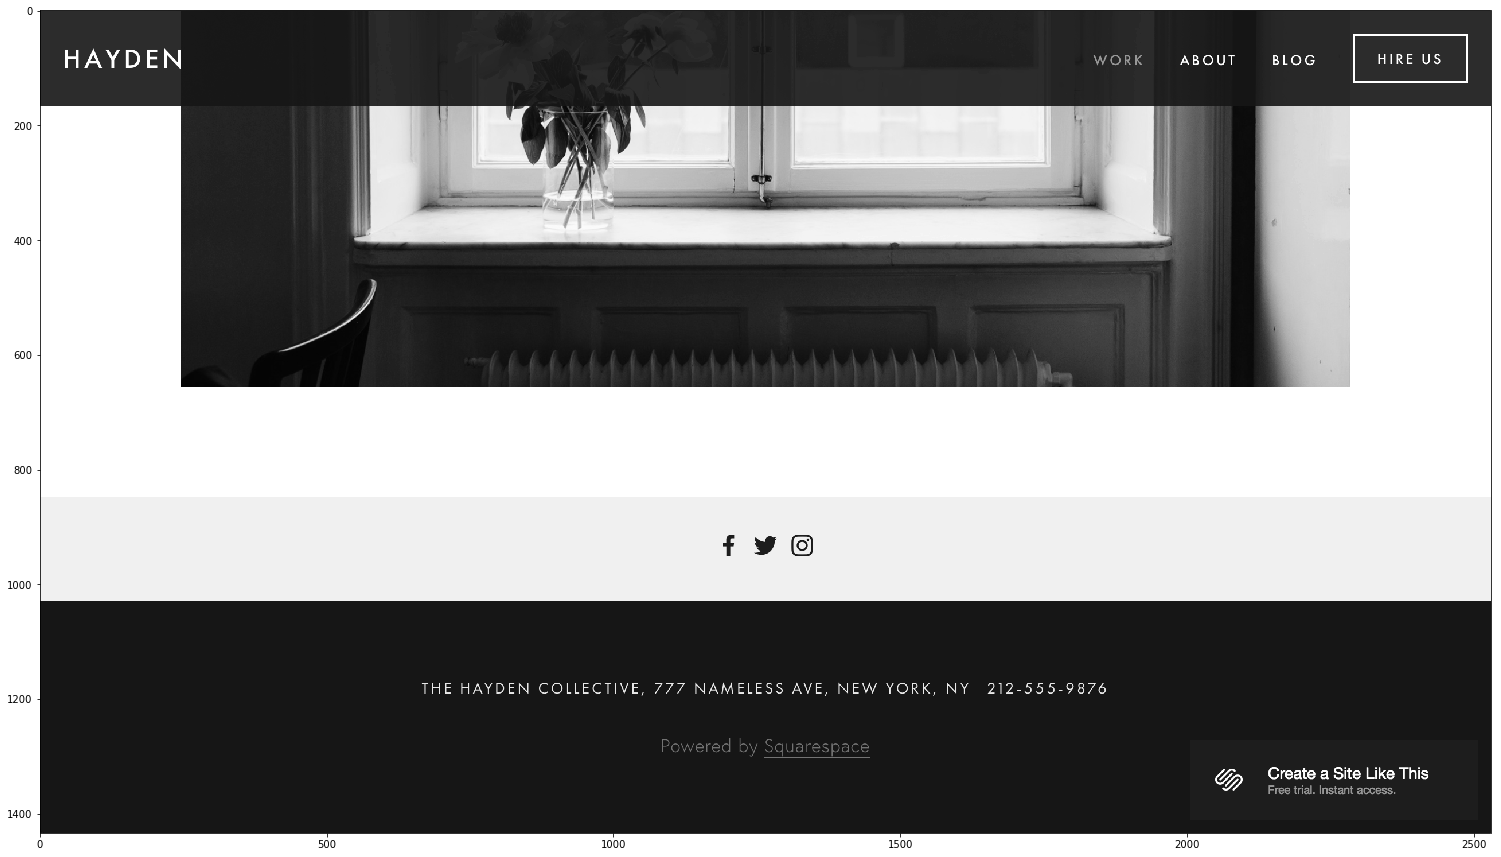

In [71]:
plt.imshow(bw_image, cmap='gray')

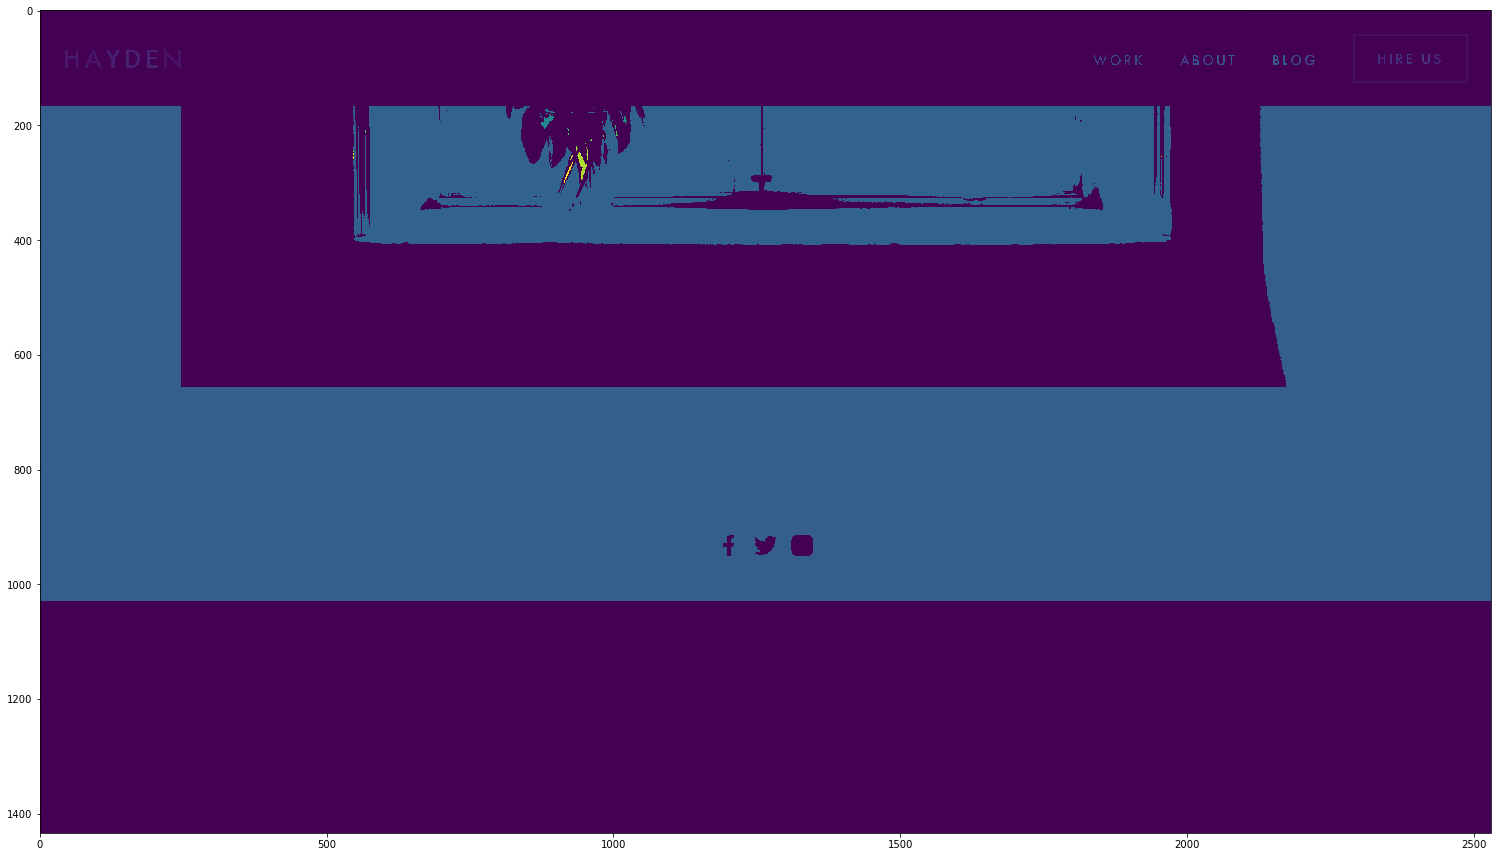

In [66]:
# labels[labels > 100] = 0
plt.imshow(labels)

imsave('hayden_connected_components.png', labels)

In [10]:
def get_top_stat_indexes(image, stats, threshold=0.05):
    top_area_indexes = np.argsort(stats[:, 4])[::-1]
    top_areas = stats[top_area_indexes, 4]
    top_area_percents = top_areas / np.prod(image.size)
    area_indexes_above_threshold = top_area_indexes[:np.argmin(top_area_percents > threshold)]
    return area_indexes_above_threshold

In [125]:


def invert_bright_connected_components(image, boundary_thickness=2, component_pct=0.02):
    
    np_image = np.array(image)[:, :, :3]

    num_labels, labels, stats, centroids = connected_components_with_black_background(image)
    top_stat_indexes = get_top_stat_indexes(image, stats, component_pct)
    for idx in range(top_stat_indexes.shape[0]):
        if top_stat_indexes[idx] == 0:
            # ignore background
            continue
        search_labels = labels == top_stat_indexes[idx]

        _, contours, _ = cv2.findContours(
            search_labels.astype(np.uint8) * 255,
            cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        search_labels = search_labels.astype(np.float)

        cv2.fillPoly(search_labels, [contours[0]], 1)
        np_image[np.where(search_labels)] = 255 - np_image[np.where(search_labels)]
        
        if boundary_thickness > 0:
            _, full_contours, _ = cv2.findContours(
                search_labels.astype(np.uint8) * 255,
                cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            contour_im = cv2.drawContours(search_labels, full_contours[0], -1, 0.5, boundary_thickness)
            np_image[np.where(contour_im == 0.5)] = 255

    return np_image

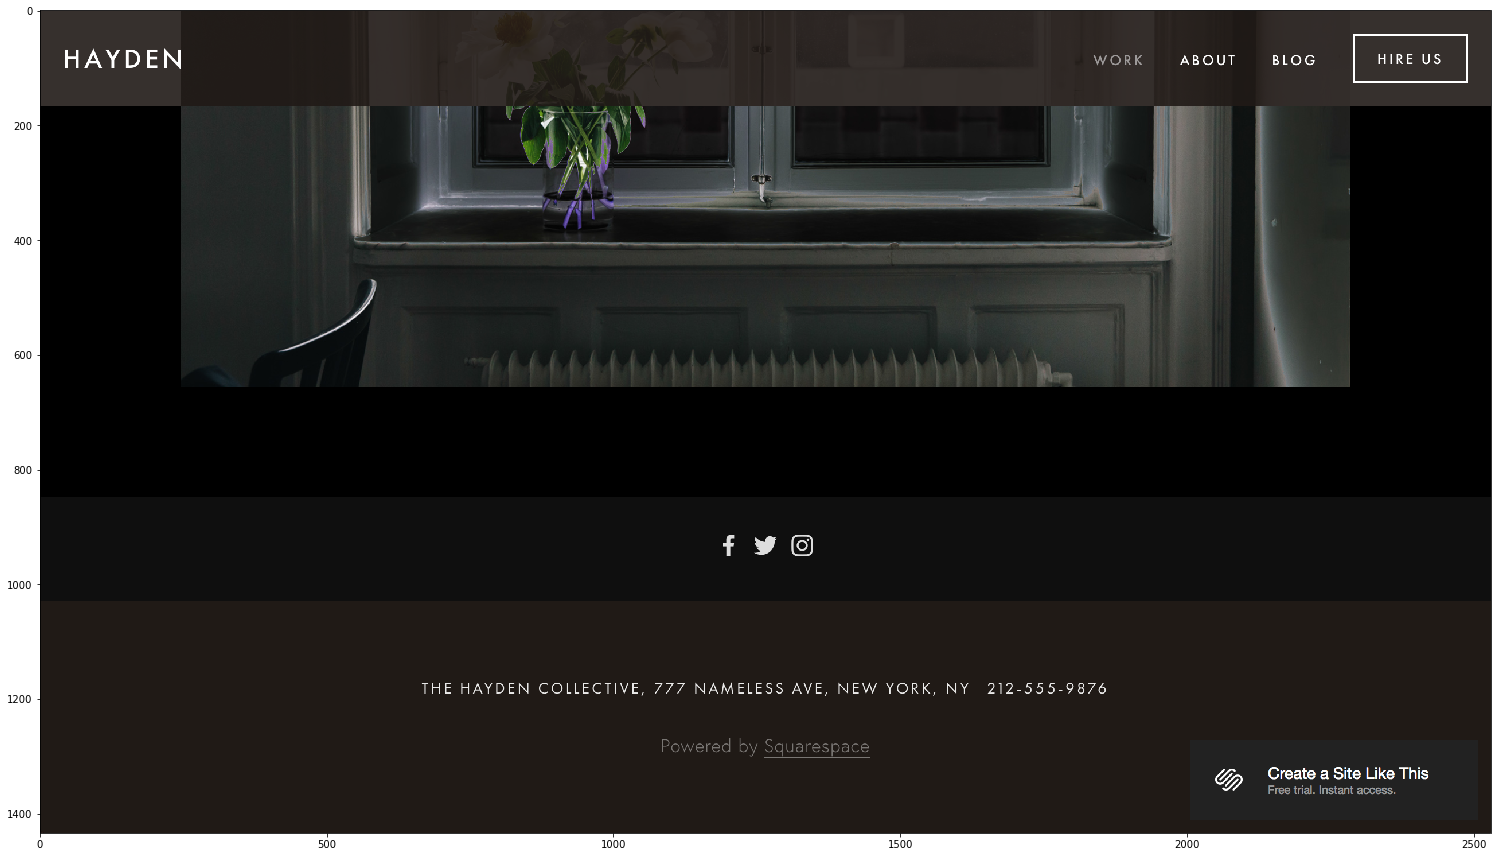

In [90]:
image = Image.open('./hayden.png', mode='r')


i = invert_bright_connected_components(image, 0, 0.01)

plt.imshow(i)

imsave('hayden_smart_invert_more.png', i)



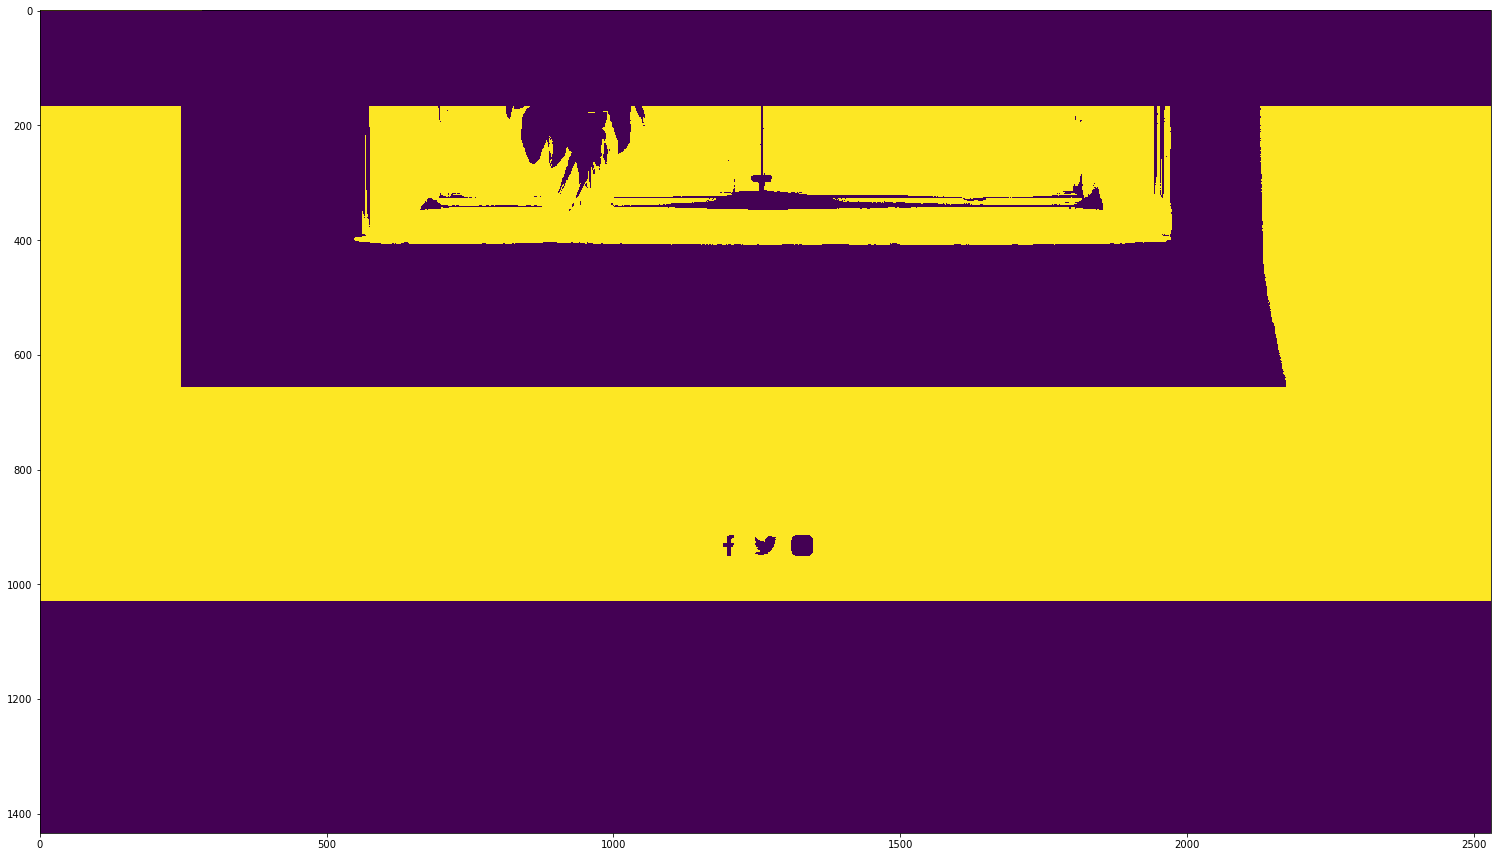

In [100]:
image = Image.open('./hayden.png', mode='r')


labels, ts = invert_bright_connected_components(image, 0, 0.001)
# plt.imshow(i)


# labels = labels[labels]
labels[labels == 32] = 1
labels[labels == 30] = 1
labels[labels != 1] = 0
plt.imshow(labels)

imsave('hayden_contour.png', labels)

In [97]:
ts

array([ 0, 30, 32])

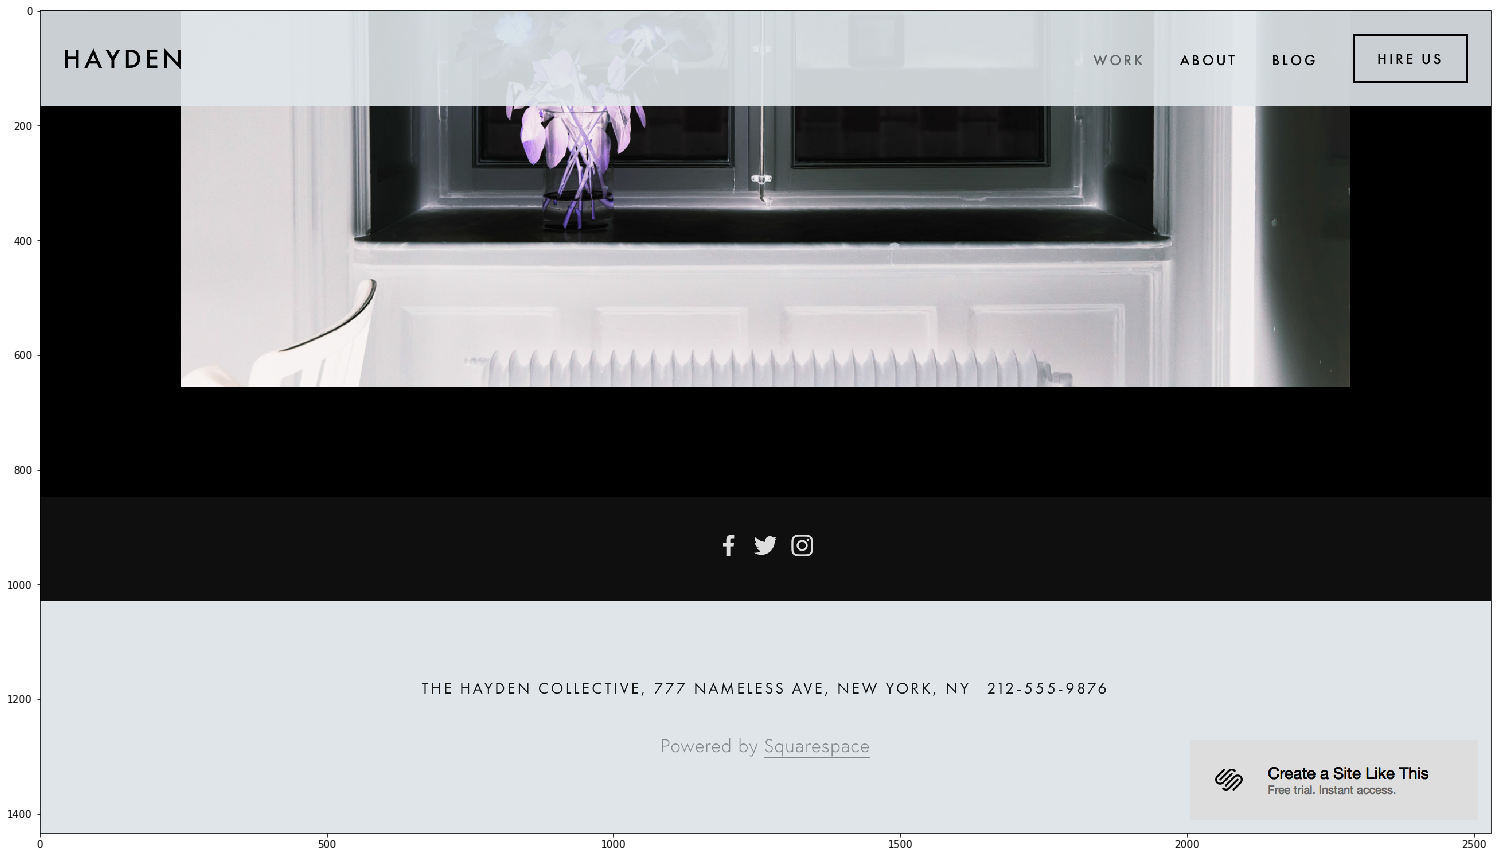

In [56]:
plt.imshow(simple_invert(image))

imsave('hayden_simple_invert.png', simple_invert(image))

In [101]:
%timeit invert_bright_connected_components(image)

10 loops, best of 3: 80.7 ms per loop


In [187]:
def genSinusoid(sz, A, omega, rho):
    # Generate Sinusoid grating
    # sz: size of generated image (width, height)
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    stimuli = A * np.cos(omega[0] * x * 50 / sz[0]) + A  * np.sin( omega[1] * y * 50 / sz[1] + rho)
    return stimuli

theta = np.pi/4
omega = [np.cos(theta), np.sin(theta)]
sinusoidParam = {'A': 10, 'omega':omega, 'rho':np.pi, 'sz':(200,200)}

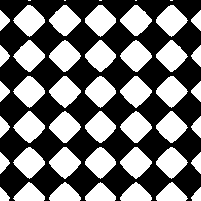

In [190]:
im = genSinusoid(**sinusoidParam) > .5
im = PIL.Image.fromarray(im.astype(np.uint8) * 255)
im = im.convert('RGB')
# im
plt.imshow(invert_bright_connected_components(im, 0, .001))

In [191]:
im.save('edge_case.png')

In [192]:
imsave('edge_case_smart_invert.png', invert_bright_connected_components(im, 0, .001))

In [193]:
imsave('edge_case_simple_invert.png', simple_invert(im))

In [194]:
imsave('edge_case_smart_invert_fix.png', invert_bright_connected_components(im, 1, .001))